In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from aggregate import aggregate
import numpy as np

In [3]:
import pandas as pd

WINDOWS = pd.read_csv(
  f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.B.paternal_recombination_rate.maternal_recombination_rate.gBGC-tract-counts.non-exonic.gBGC.bed', 
  sep='\t', 
)
WINDOWS 

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,gBGC-tract_overlap_count,log10_paternal_recombination_rate,log10_maternal_recombination_rate,B_M1star.EUR,Bmean_M3starPop.EUR,Bmean_M3starHM.EUR,Bmean_M3starHMT6.EUR
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653,0.039046,0.025852,0,-1.408422,-1.587499,0.108103,0.102972,0.108093,0.105518
1,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652,0.039046,0.025852,0,-1.408422,-1.587499,0.108103,0.102972,0.108093,0.105518
2,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499,0.108103,0.102972,0.108093,0.105518
3,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499,0.108103,0.102972,0.108093,0.105518
4,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651,0.039046,0.025852,0,-1.408422,-1.587499,0.108103,0.102972,0.108093,0.105518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019237,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675,0.165515,0.186431,0.186357,0.219258
1019238,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675,0.165515,0.186431,0.186357,0.219258
1019239,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536,0.057053,0.063434,0,-1.243724,-1.197675,0.165515,0.186431,0.186357,0.219258
1019240,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536,1.564889,0.024254,0,0.194484,-1.615221,0.165515,0.186431,0.186357,0.219258


## For those non-exonic Chen windows subject to large gBGC coefficients, the model overestimates the observed SNV count more often than it underestimates it, and vice versa

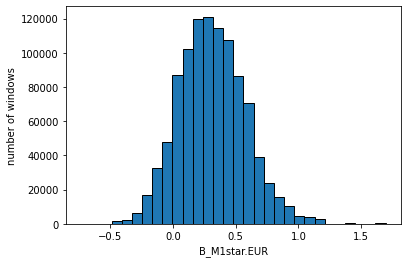

In [4]:
def plot_gBGC_distribution(df, gBGC):
  plt.hist(df[gBGC], bins=30, edgecolor='black')
  plt.xlabel(gBGC)
  plt.ylabel('number of windows')

plot_gBGC_distribution(WINDOWS, gBGC='B_M1star.EUR')

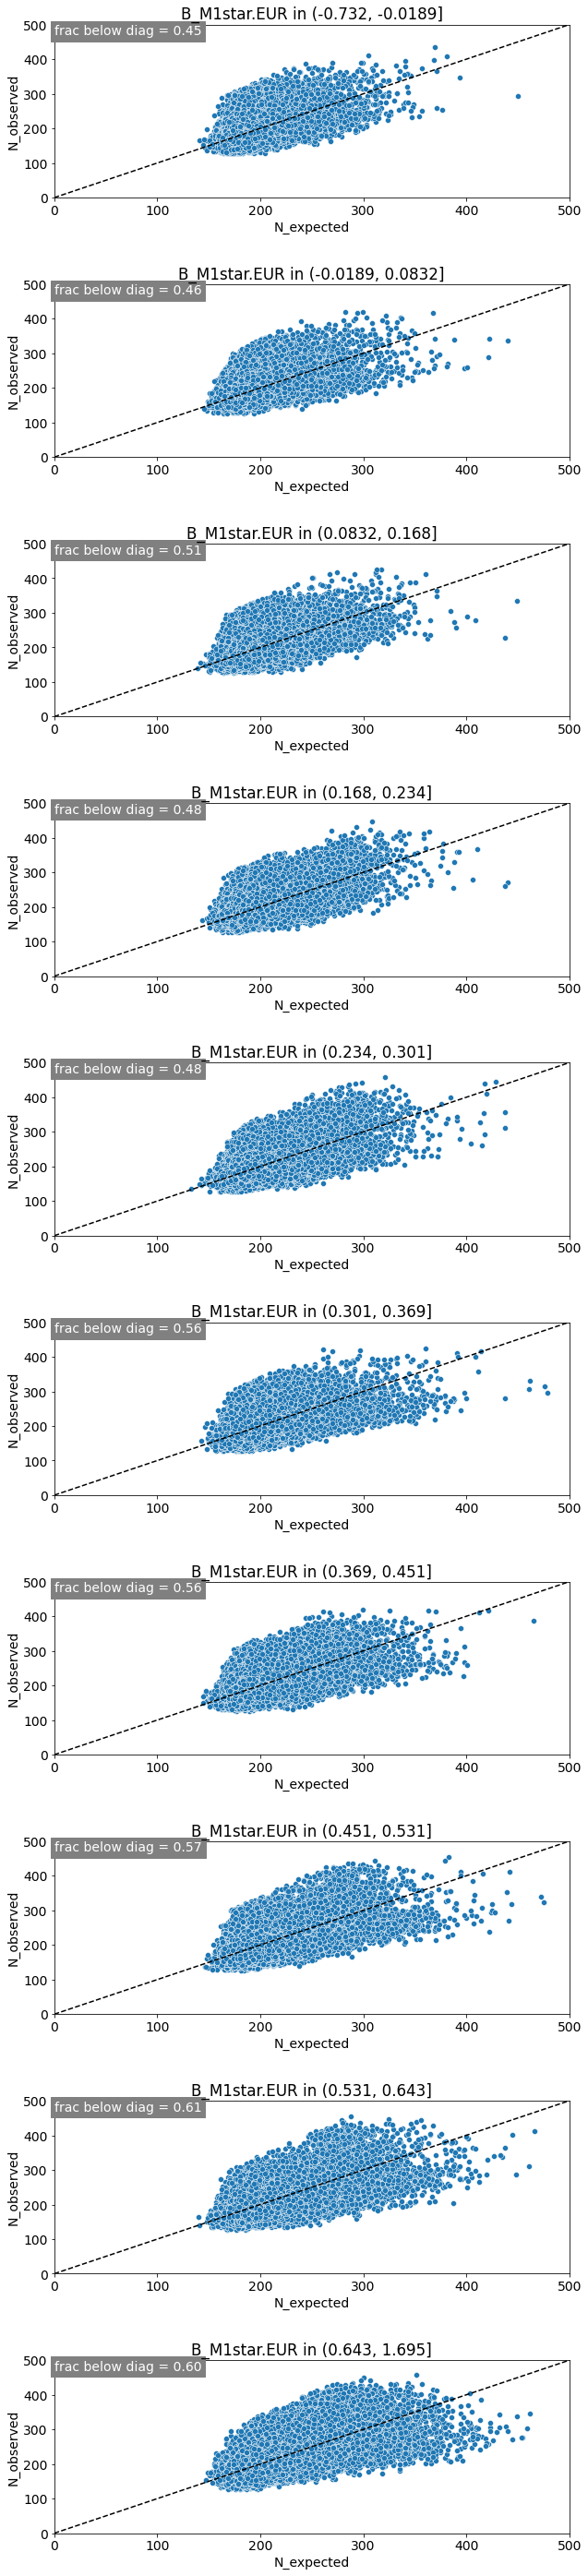

In [5]:
plt.rcParams.update({
  'font.size': 14,
})

def correlate_observed_counts_with_expected_counts(df, feature, number_quantiles=10): 
  df = df.copy() 
  
  df = df.dropna(subset=[feature])  

  df[f'{feature}_range'] = pd.qcut(df[feature], q=number_quantiles, labels=None, retbins=False)

  fig, axs = plt.subplots(number_quantiles, 1, figsize=(10, 50))
  plt.subplots_adjust(hspace=0.5)
  for i, quantile in enumerate(sorted(df[f'{feature}_range'].unique())): 
    df_quantile = df[df[f'{feature}_range'] == quantile]
    sns.scatterplot(
      data=df_quantile, 
      x='N_expected', 
      y='N_observed', 
      ax=axs[i],
    )
    axs[i].plot([0, 500], [0, 500], color='black', linestyle='--')
    axs[i].set_title(f'{feature} in {quantile}')

    # r = df_b_range['N_expected'].corr(df_b_range['N_observed'])
    # axs[i].text(50, 500, f'r = {r:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    fraction_below_diagonal = (df_quantile['N_observed'] < df_quantile['N_expected']).sum() / len(df_quantile)
    axs[i].text(0, 500, f'frac below diag = {fraction_below_diagonal:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    # gnocchi_threshold = 3
    # fraction_gnocchi = (df_b_range['gnocchi'] > gnocchi_threshold).sum() / len(df_b_range)
    # axs[i].text(0, 450, f'frac gnocchi > {gnocchi_threshold} = {fraction_gnocchi:.3f}', ha='left', va='top', backgroundcolor='grey', color='white')
  
    # x = df_b_range['N_expected']
    # y = df_b_range['N_observed']
    # model = LinearRegression()
    # model.fit(x.values.reshape(-1, 1), y)
    # slope = model.coef_[0]
    # intercept = model.intercept_
    # axs[i].text(50, 400, f'slope = {slope:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')
    # xs = np.array([0, 500])
    # ys = slope * xs + intercept
    # axs[i].plot(xs, ys, color='red', linestyle='--')

    axs[i].set_xlim(0, 500)
    axs[i].set_ylim(0, 500)
    
correlate_observed_counts_with_expected_counts(WINDOWS, feature='B_M1star.EUR')

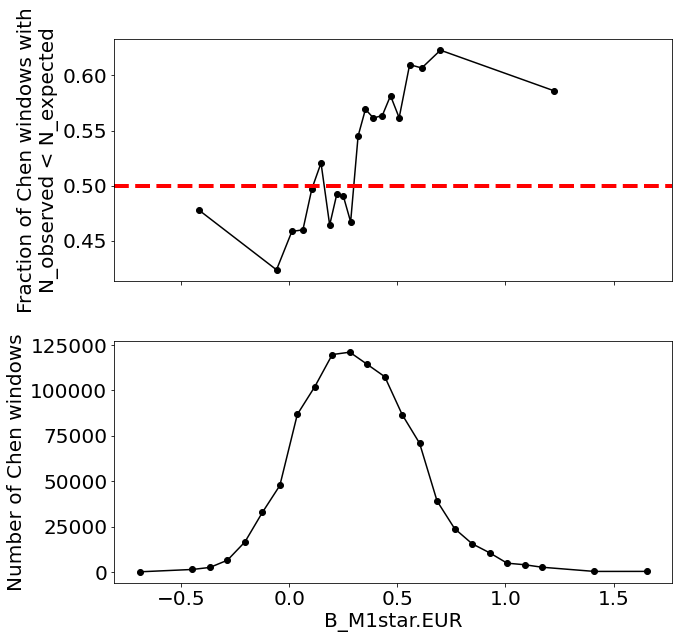

In [6]:
plt.rcParams.update({
  'font.size': 20,
})

def plot_fraction_below_diag(df, feature, number_quantiles=20, number_bins=30, ylim=None):  
  df = df.copy() 

  df = df.dropna(subset=[feature])  

  df[f'{feature}_quantile'] = pd.qcut(df[feature], q=number_quantiles, labels=None, retbins=False)
  df[f'{feature}_bin'] = pd.cut(df[feature], bins=number_bins)

  df[f'{feature}_quantile_mid'] = df[f'{feature}_quantile'].apply(lambda x: x.mid).astype(float)
  df[f'{feature}_bin_mid'] = df[f'{feature}_bin'].apply(lambda x: x.mid).astype(float)

  df['below_diag'] = df['N_observed'] < df['N_expected']

  df_by_quantile = aggregate(
    df, 
    group_columns = [f'{feature}_quantile_mid'],
    aggregation_functions = {
      'below_diag': [np.mean],
    }
  )
  df_by_quantile = df_by_quantile.rename(columns={
    'mean below_diag': 'fraction_below_diag',
  })
  
  df_by_bin = aggregate(
    df, 
    group_columns = [f'{feature}_bin_mid'],
    aggregation_functions = {
      feature: ['count']
    }
  )

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  axs[0].plot(df_by_quantile[f'{feature}_quantile_mid'], df_by_quantile['fraction_below_diag'], 'o-', color='black')
  axs[0].axhline(y=0.5, color='red', linestyle='--', linewidth=4)
  axs[0].set_ylabel('Fraction of Chen windows with\nN_observed < N_expected')
  axs[0].set_ylim(ylim)

  axs[1].plot(df_by_bin[f'{feature}_bin_mid'], df_by_bin[f'count {feature}'], 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')

  axs[1].set_xlabel(feature)

plot_fraction_below_diag(WINDOWS, feature='B_M1star.EUR')  

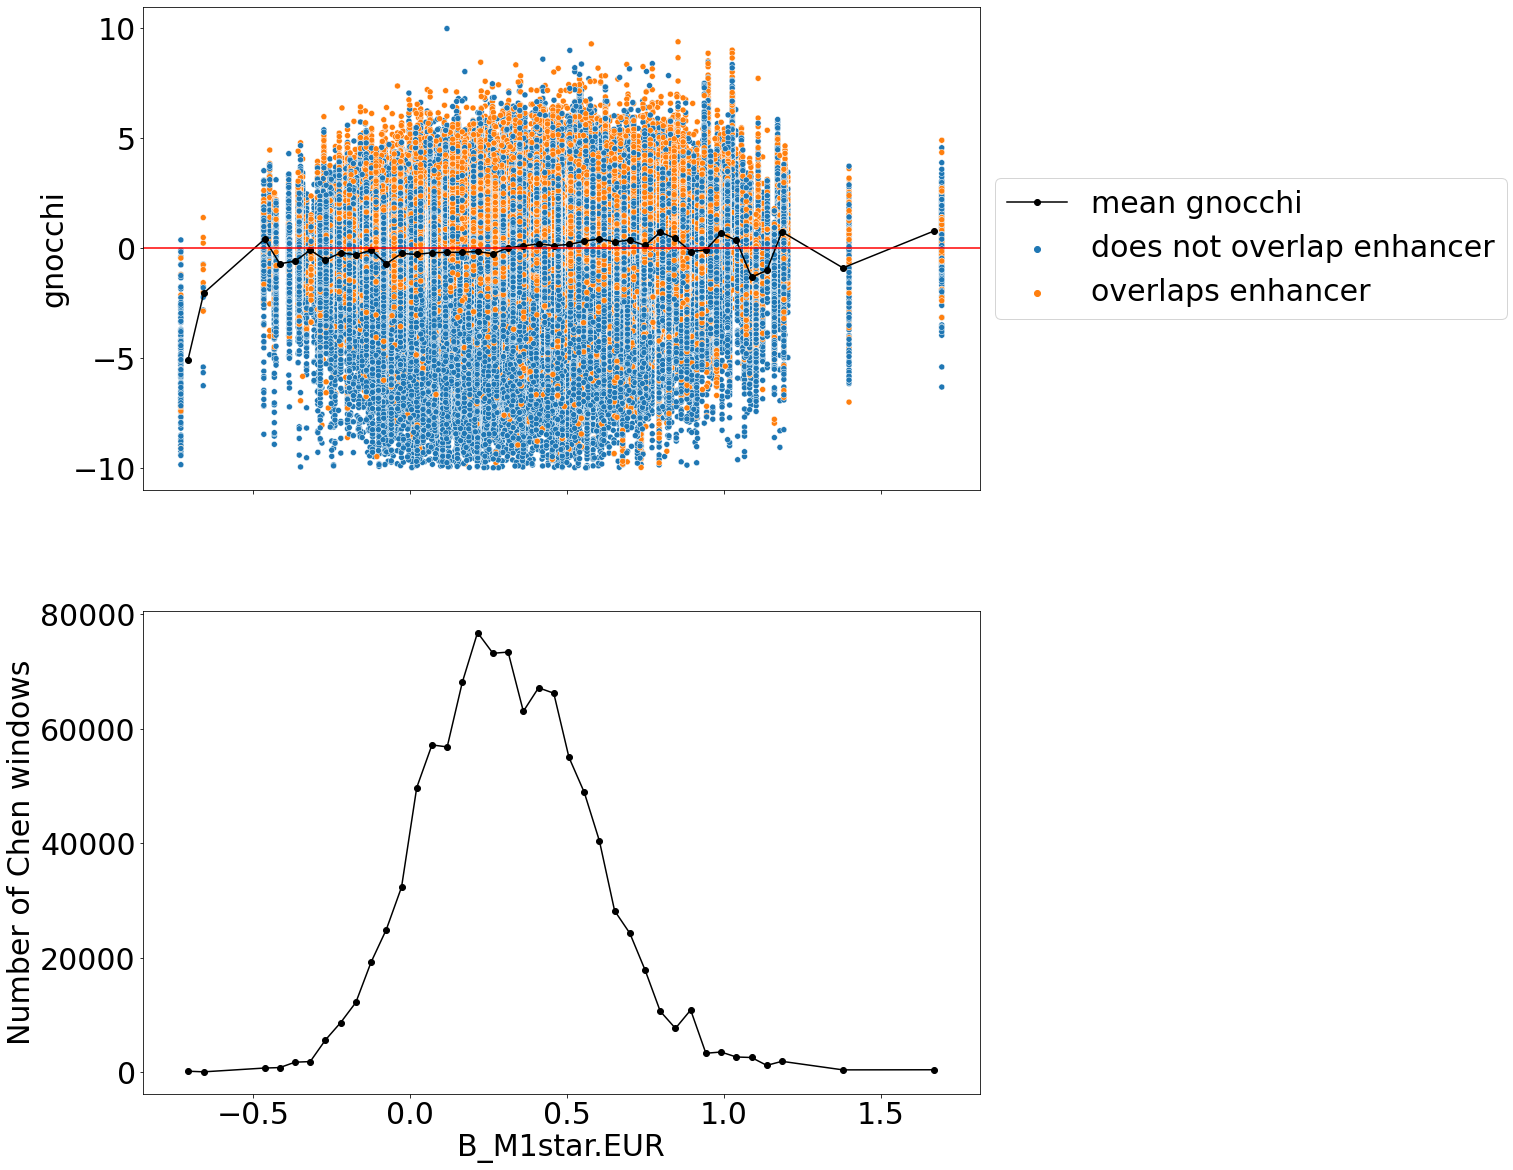

In [7]:
plt.rcParams.update({
  'font.size': 30,
})

def plot_mean_gnocchi(df, feature, number_bins=50): 
  df = df.copy()

  df[f'{feature}_bin'] = pd.cut(df[feature], bins=number_bins)
  df[f'{feature}_bin_mid'] = df[f'{feature}_bin'].apply(lambda x: x.mid).astype(float)
  df_aggregated = aggregate(
    df, 
    group_columns = [f'{feature}_bin_mid'],
    aggregation_functions = {
      'gnocchi': [np.mean],
      feature: ['count']
    }
  )

  fig, axs = plt.subplots(2, 1, figsize=(15, 20), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  sns.scatterplot(
    data=df, 
    x=feature, 
    y='gnocchi', 
    hue='window overlaps enhancer',
    ax=axs[0],
  )
  axs[0].plot(df_aggregated[f'{feature}_bin_mid'], df_aggregated['mean gnocchi'], 'o-', color='black', label='mean gnocchi')
  axs[0].axhline(0, color='red')  # Add this line to plot a horizontal line at y=0
  axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

  handles, labels = axs[0].get_legend_handles_labels()
  labels[1] = 'does not overlap enhancer'
  labels[2] = 'overlaps enhancer'
  axs[0].legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

  axs[1].plot(df_aggregated[f'{feature}_bin_mid'], df_aggregated[f'count {feature}'], 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')

  axs[1].set_xlabel(feature)
  
plot_mean_gnocchi(WINDOWS, feature='B_M1star.EUR')

## Gnocchi-based calls of constraint, but not enhancers, are enriched in regions with high gBGC coefficients, and depleted in regions with low gBGC coefficients

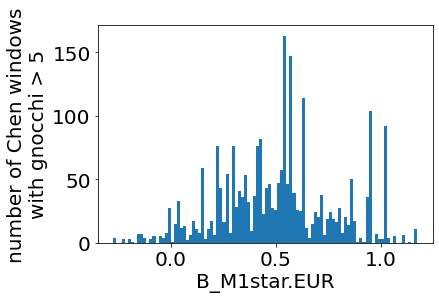

In [8]:
plt.rcParams.update({
  'font.size': 20,
})

def plot_distribution_of_feature_for_gnocchi_calls(df, feature, gnocchi_threshold): 
  df = df.copy() 
  df = df[df['gnocchi'] > gnocchi_threshold]
  df.plot.hist(y=feature, bins=100)
  plt.xlabel(feature)
  plt.ylabel(f'number of Chen windows\nwith gnocchi > {gnocchi_threshold}')
  plt.legend().remove()

plot_distribution_of_feature_for_gnocchi_calls(WINDOWS, feature='B_M1star.EUR', gnocchi_threshold=5) 

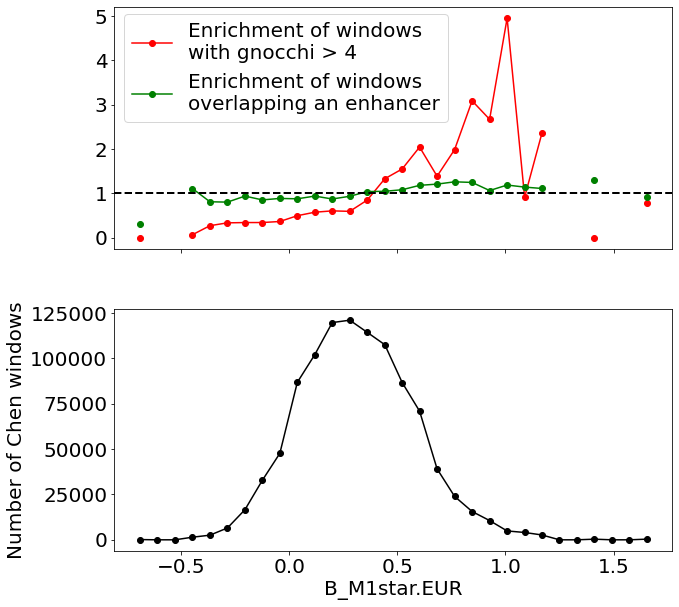

In [20]:
def plot_enrichment_of_windows(df, feature, gnocchi_threshold, sign, number_bins=30, ylim=None): 
  df = df.copy() 

  df[f'{feature}_bin'] = pd.cut(df[feature], bins=number_bins)
  
  total_counts = df[f'{feature}_bin'].value_counts().sort_index()
  total_frac = total_counts/total_counts.sum()

  if sign == '>':
    gnocchi_calls = df[df['gnocchi'] > gnocchi_threshold]
  elif sign == '<': 
    gnocchi_calls = df[df['gnocchi'] < gnocchi_threshold]
  gnocchi_counts = gnocchi_calls[f'{feature}_bin'].value_counts().sort_index()
  gnocchi_frac = gnocchi_counts / gnocchi_counts.sum() 

  enhancer_counts = df[df['window overlaps enhancer'] == True][f'{feature}_bin'].value_counts().sort_index()
  enhancer_frac = enhancer_counts / enhancer_counts.sum() 

  gnocchi_enrichment = gnocchi_frac / total_frac
  enhancer_enrichment = enhancer_frac / total_frac
  
  total_counts.index = total_counts.index.map(lambda x: x.mid)
  gnocchi_enrichment.index = gnocchi_enrichment.index.map(lambda x: x.mid)
  enhancer_enrichment.index = enhancer_enrichment.index.map(lambda x: x.mid)

  plt.rcParams.update({'font.size': 20})

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  axs[0].plot(gnocchi_enrichment.index, gnocchi_enrichment, 'o-', color='red', label=f'Enrichment of windows\nwith gnocchi {sign} {gnocchi_threshold}')
  axs[0].plot(enhancer_enrichment.index, enhancer_enrichment, 'o-', color='green', label=f'Enrichment of windows\noverlapping an enhancer')
  axs[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
  axs[0].set_ylim(ylim)
  axs[0].legend(bbox_to_anchor=(0, 0.75), loc='center left')

  axs[1].plot(total_counts.index, total_counts, 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')
  axs[1].set_xlabel(feature)

plot_enrichment_of_windows(WINDOWS, gnocchi_threshold=4, sign='>', feature='B_M1star.EUR')

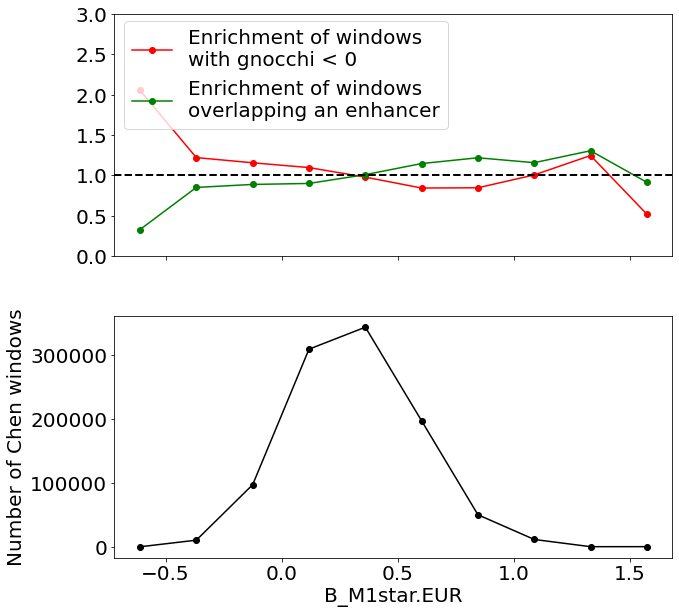

In [10]:
plot_enrichment_of_windows(WINDOWS, gnocchi_threshold=0, sign='<', feature='B_M1star.EUR', ylim=(0, 3), number_bins=10)

## gBGC is enriched in regions with B > 0.9

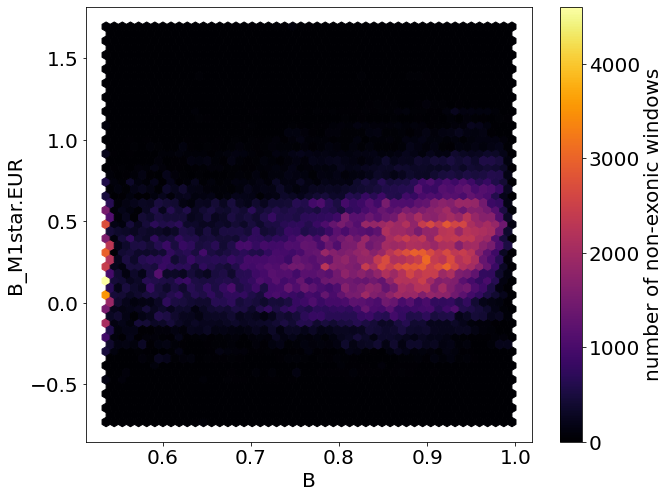

In [11]:
def correlate_gBGC_vs_B(df, gBGC_feature):
  plt.figure(figsize=(10, 8))  
  plt.hexbin(df['B'], df[gBGC_feature], gridsize=50, cmap='inferno')
  plt.xlabel('B')
  plt.ylabel(gBGC_feature)
  plt.colorbar(label='number of non-exonic windows')

correlate_gBGC_vs_B(WINDOWS, gBGC_feature='B_M1star.EUR')